In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import tables as tb
import datetime
import os

from scipy.fftpack import rfft, fftshift, fft
from scipy.optimize import least_squares
from numpy import pi
from scipy.signal import tukey, bartlett
from scipy.signal import correlate

from matplotlib import pyplot as plt; plt.rcParams['figure.figsize'] = 15, 5

DATA_DIR = '../data/interim/'
HDF_FILE = 'interim_data.hdf'

In [2]:
D = pd.read_hdf(DATA_DIR + HDF_FILE, key = '/temperature_ts/wban_94797/D')
t = D.index
T = D['T'].values
T = T - np.mean(T)
dT = D['dT'].values

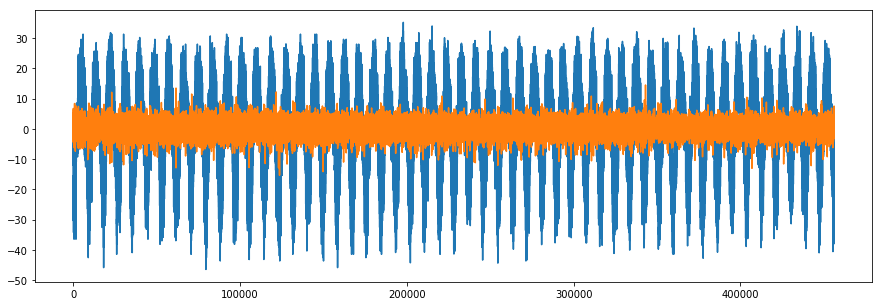

In [3]:
plt.plot(T)
plt.plot(dT)

In [43]:
N = len(T)  # number of discrete frequenies
T_sample = 3600.  # 1 sample every hour

In [5]:
ST = fft(T)[0: N // 2]
f = np.linspace(0, 24 * 3600 / (2 * T_sample), N // 2)  # Frequency in 1/days
ST = pd.DataFrame(index=f, data=np.abs(ST))

In the plot below we see spikes at frequencies of 1/day, as well as the associated harmonics.

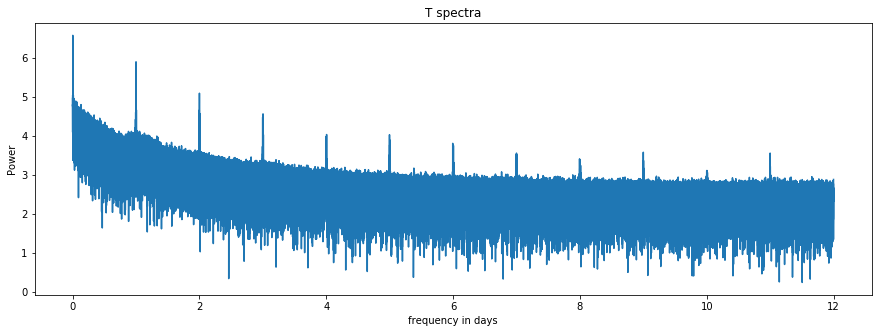

In [6]:
plt.plot(ST.index[1:], np.log10(ST.values)[1:])
#plt.plot(f[1:N_final], 20.0 / len(T) * np.log10(np.abs(ST[1:N_final])))
plt.xlabel('frequency in days')
plt.ylabel('Power')
plt.title('T spectra')

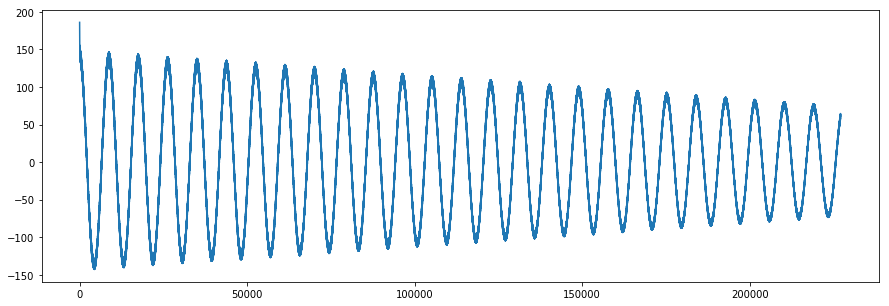

In [9]:
rx = (1. / N) * correlate(T, T, mode = 'same')
plt.plot(fftshift(rx)[0:N//2])

In [10]:
# THIS METHOD OF FINDING THE PEAKS IS COMPLETELY NON-ROBUST
a = np.argsort(-ST.values.flatten())

# Frequeny in units of days
f0_yr = ST.index[a[0]]
f0_d = ST.index[a[1]]
print(f0_yr, f0_d)

0.00273515063053 1.00001314976


In [21]:
print(a[0:25])
f_yr = f[52]
f_d = f[19012]
f_hd = f[38024]
print(f_yr, f_d, f_hd)

[   52 19012   104    53 19064    51   156 19011 38024 18960   208     1
    79    14    54 19013   474   435   531    34   198    50   338   288
    97]
0.00273515063053 1.00001314976 2.00002629953


In [34]:
unix_birth = datetime.datetime(1970, 1, 1)
time_in_days = lambda t: (t - unix_birth).total_seconds() / 86400  # 86400 = timedelta(days=1).total_seconds()
t_days = np.fromiter(map(time_in_days, t), np.float64)  # Time indices in units of days

In [29]:
# Error functions for sinusoidal regression
def err_f0(theta):  # No frequency optimization
    a_yr, a_d, a_hd, phi_yr, phi_d, phi_hd = theta
    syr = a_yr * np.sin(2*pi*f_yr*t_days + phi_yr)
    sd = a_d * np.sin(2*pi*f_d*t_days + phi_d)
    shd = a_hd * np.sin(2*pi*f_hd*t_days + phi_hd)
    return T - syr - sd - shd

In [24]:
res = least_squares(err_f0, (1, 1, 1, 0, 0, 0), method='lm', loss='linear', verbose=1)
a_yr, a_d, a_hd, phi_yr, phi_d, phi_hd = res.x
print('theta0:', res.x)
print('Optimality:', res.optimality)
print('status:', res.status)
print('message:', res.message)
print('success:', res.success)

x_hat = a_yr * np.sin(2*pi*f_yr*t_days + phi_yr) + a_d * np.sin(2*pi*f_d*t_days + phi_d) +\
        a_hd * np.sin(2*pi*f_hd*t_days + phi_hd)

`ftol` termination condition is satisfied.
Function evaluations 149, initial cost 4.4446e+07, final cost 9.8045e+06, first-order optimality 4.79e+01.
theta0: [-16.60047682  -3.1943592   -0.38817224  -5.00236509  -0.68929934
   1.13856842]
Optimality: 47.8960861666
status: 2
message: `ftol` termination condition is satisfied.
success: True


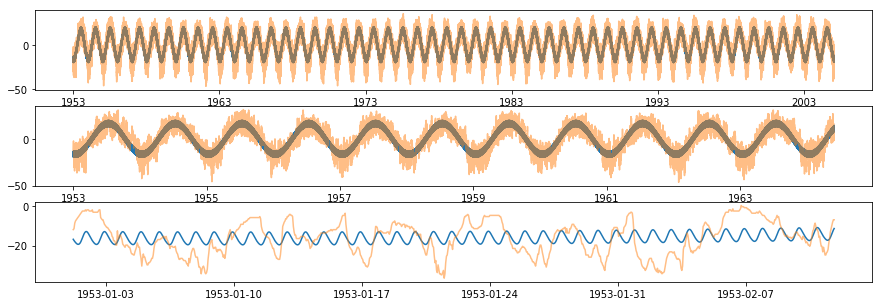

In [25]:
fig, axes = plt.subplots(3, 1)
ax0, ax1, ax2 = axes
ax0.plot(t, x_hat); ax0.plot(t, T, alpha=0.5)
ax1.plot(t[0:100000], x_hat[0:100000]); ax1.plot(t[0:100000], T[0:100000], alpha=0.5)
ax2.plot(t[0:1000], x_hat[0:1000]); ax2.plot(t[0:1000], T[0:1000], alpha=0.5)

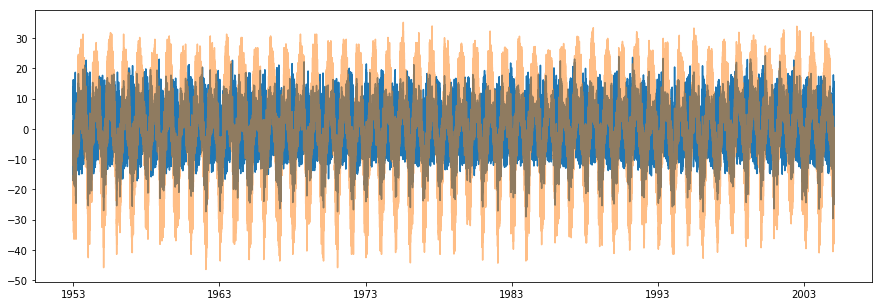

In [51]:
T1 = T - x_hat
plt.plot(t, T1)
plt.plot(t, T, alpha = 0.5)

In [52]:
N = len(T1)
ST1 = fft(T1)[:N // 2]
ST1 = pd.DataFrame(index=f, data=np.abs(ST1))

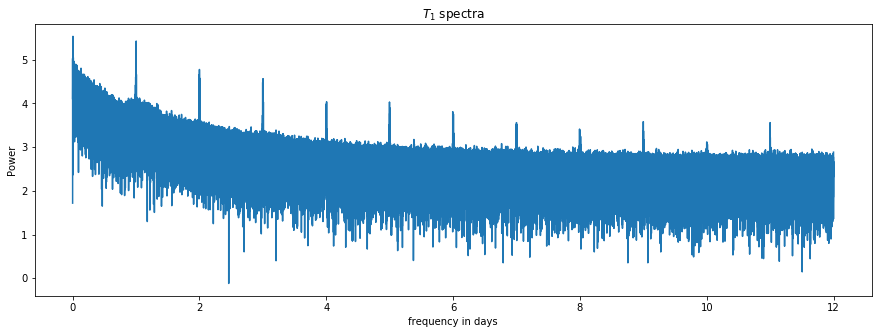

In [53]:
plt.plot(ST1.index, np.log10(ST1.values))
#plt.plot(f[1:N_final], 20.0 / len(T) * np.log10(np.abs(ST[1:N_final])))
plt.xlabel('frequency in days')
plt.ylabel('Power')
plt.title('$T_1$ spectra')

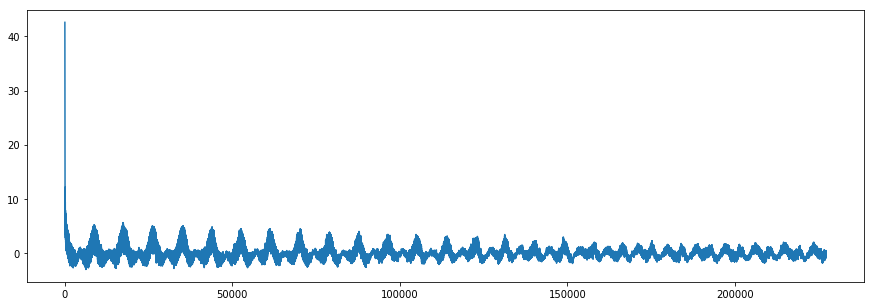

In [55]:
rx = (1. / N) * correlate(T1, T1, mode = 'same')
plt.plot(fftshift(rx)[0:N//2])

Repeating the process is not useful

In [60]:
print(a[0:25])
f0_yr = f[52]
f0_d = f[19012]
print(f0_yr, f0_d)

[   52 19012   104    53 19064    51   156 19011 38024 18960   208     1
    79    14    54 19013   474   435   531    34   198    50   338   288
    97]
0.00273515063053 1.00001314976


In [61]:
# Error functions for sinusoidal regression
def err_f1(theta):  # No frequency optimization
    a_yr, a_d, phi_yr, phi_d = theta
    syr = a_yr * np.sin(2*pi*f0_yr*t_days + phi_yr)
    sd = a_d * np.sin(2*pi*f0_d*t_days + phi_d)
    return T1 - syr - sd

In [62]:
res0 = least_squares(err_f1, (1, 1, 0, 0), method='lm', loss='linear', verbose=1)
a0_yr, a0_d, phi0_yr, phi0_d = res0.x
print('theta0:', res0.x)
print('Optimality:', res0.optimality)
print('status:', res0.status)
print('message:', res0.message)
print('success:', res0.success)

x_hat = a_yr * np.sin(2*pi*f0_yr*t_days + phi_yr) + a_d * np.sin(2*pi*f0_d*t_days + phi_d)

`ftol` termination condition is satisfied.
Function evaluations 29, initial cost 1.0033e+07, final cost 9.8045e+06, first-order optimality 7.99e-04.
theta0: [ -1.76047554e-09  -4.17691145e-05   1.16616858e-09  -5.06772707e-05]
Optimality: 0.000798635413329
status: 2
message: `ftol` termination condition is satisfied.
success: True


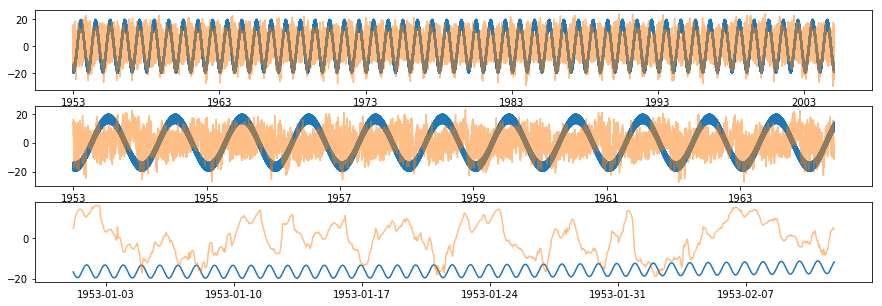

In [63]:
fig, axes = plt.subplots(3, 1)
ax0, ax1, ax2 = axes
ax0.plot(t, x_hat); ax0.plot(t, T1, alpha=0.5)
ax1.plot(t[0:100000], x_hat[0:100000]); ax1.plot(t[0:100000], T1[0:100000], alpha=0.5)
ax2.plot(t[0:1000], x_hat[0:1000]); ax2.plot(t[0:1000], T1[0:1000], alpha=0.5)